In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

import xgboost as xgb
from sklearn.metrics import accuracy_score
import seaborn as sns


In [3]:
df = pd.read_csv('train.csv')
df = df.drop(columns=['id','Policy_Sales_Channel'])
df = pd.get_dummies(df, columns=['Gender','Vehicle_Age','Vehicle_Damage'], drop_first=True)
scaler = MinMaxScaler()
df[['Age','Annual_Premium','Vintage']] = scaler.fit_transform(df[['Age','Annual_Premium','Vintage']])
df['Region_Code'] = df['Region_Code'].apply(lambda x: 1 if x==28 else 0)
df

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Vintage,Response,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,0.369231,1,1,0,0.070366,0.716263,1,1,0,1,1
1,0.861538,1,0,0,0.057496,0.598616,0,1,0,0,0
2,0.415385,1,1,0,0.066347,0.058824,1,1,0,1,1
3,0.015385,1,0,1,0.048348,0.667820,0,1,1,0,0
4,0.138462,1,0,1,0.046259,0.100346,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
381104,0.830769,1,0,1,0.051234,0.269896,0,1,0,0,0
381105,0.153846,1,0,1,0.069551,0.418685,0,1,1,0,0
381106,0.015385,1,0,1,0.060439,0.522491,0,1,1,0,0
381107,0.738462,1,0,0,0.078110,0.221453,0,0,0,1,1


In [4]:
df = df.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Less_1Year", "Vehicle_Age_> 2 Years": "Vehicle_More_2Year" }, errors="raise")

In [5]:
df.corr()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Vintage,Response,Gender_Male,Vehicle_Less_1Year,Vehicle_More_2Year,Vehicle_Damage_Yes
Age,1.000000,-0.079782,0.298304,-0.254682,0.067507,-0.001264,0.111147,0.145545,-0.787775,0.220694,0.267534
Driving_License,-0.079782,1.000000,-0.016017,0.014969,-0.011906,-0.000848,0.010155,-0.018374,0.040215,-0.006211,-0.016622
Region_Code,0.298304,-0.016017,1.000000,-0.182873,0.293050,0.000369,0.122609,0.029822,-0.325856,0.147437,0.193135
Previously_Insured,-0.254682,0.014969,-0.182873,1.000000,0.004269,0.002537,-0.341170,-0.081932,0.358773,-0.191352,-0.824143
Annual_Premium,0.067507,-0.011906,0.293050,0.004269,1.000000,-0.000608,0.022575,0.003673,-0.022555,0.061918,0.009349
Vintage,-0.001264,-0.000848,0.000369,0.002537,-0.000608,1.000000,-0.001050,-0.002517,0.002410,0.000600,-0.002064
Response,0.111147,0.010155,0.122609,-0.341170,0.022575,-0.001050,1.000000,0.052440,-0.209878,0.109300,0.354400
Gender_Male,0.145545,-0.018374,0.029822,-0.081932,0.003673,-0.002517,0.052440,1.000000,-0.166280,0.043155,0.091606
Vehicle_Less_1Year,-0.787775,0.040215,-0.325856,0.358773,-0.022555,0.002410,-0.209878,-0.166280,1.000000,-0.182750,-0.370778
Vehicle_More_2Year,0.220694,-0.006211,0.147437,-0.191352,0.061918,0.000600,0.109300,0.043155,-0.182750,1.000000,0.206961


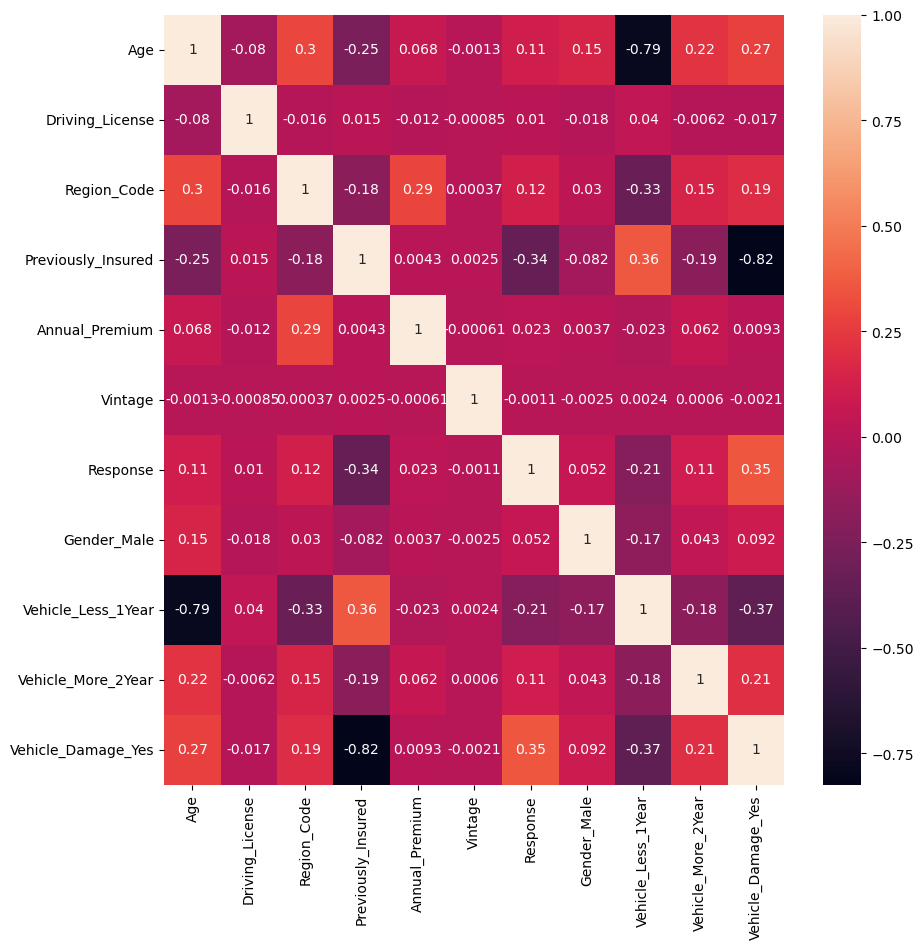

In [8]:
fig, ax = plt.subplots(figsize=(10,10))   
dataplot = sns.heatmap(df.corr(), annot=True, ax = ax)

# Clear correlation columns:
Previous Insured corr with vehicle Damaged
Age corr with Vehicle Less 1 Year.

# Option 1: Not drop columns + XGBoost

In [9]:
#Train, test split
x = df.drop(columns=['Response'])
y = df['Response']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42, stratify=y)


              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66880
           1       0.38      0.01      0.01      9342

    accuracy                           0.88     76222
   macro avg       0.63      0.50      0.47     76222
weighted avg       0.82      0.88      0.82     76222



C:\Users\vy\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


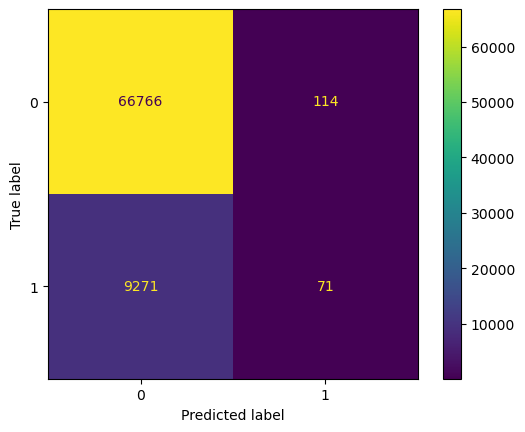

In [10]:
model_xgb = xgb.XGBClassifier(random_state=42, n_estimators=100)
model_xgb.fit(x_train, y_train)


y_pred = model_xgb.predict(x_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(model_xgb, x_test, y_test)

# Logistic Regression

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66880
           1       0.00      0.00      0.00      9342

    accuracy                           0.88     76222
   macro avg       0.44      0.50      0.47     76222
weighted avg       0.77      0.88      0.82     76222



C:\Users\vy\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


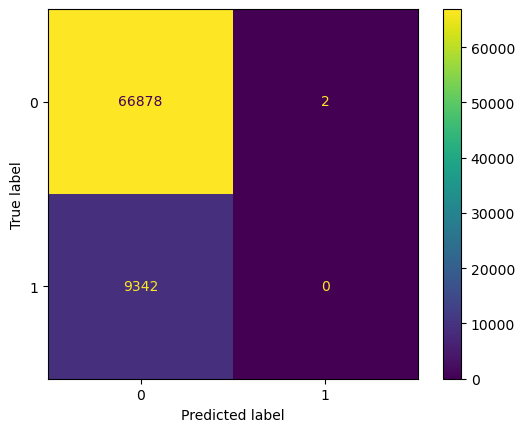

In [11]:
from sklearn.linear_model import LogisticRegression
model_log = LogisticRegression()
model_log.fit(x_train, y_train)
y_pred = model_log.predict(x_test)

print(classification_report( y_test, y_pred))
plot_confusion_matrix(model_log, x_test, y_test)

              precision    recall  f1-score   support

           0       0.99      0.59      0.74     66880
           1       0.25      0.97      0.40      9342

    accuracy                           0.64     76222
   macro avg       0.62      0.78      0.57     76222
weighted avg       0.90      0.64      0.70     76222



C:\Users\vy\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


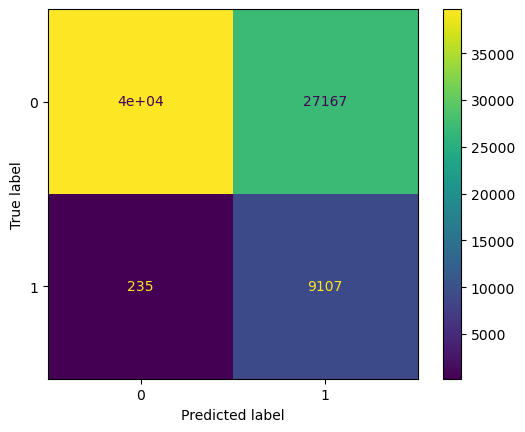

In [12]:
# Try solution for imbalance data
# Class Weight
model2 = LogisticRegression(class_weight='balanced')
model2.fit(x_train, y_train)

y_pred = model2.predict(x_test)

print(classification_report( y_test, y_pred))
plot_confusion_matrix(model2, x_test, y_test)

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     66880
           1       0.31      0.15      0.20      9342

    accuracy                           0.85     76222
   macro avg       0.60      0.55      0.56     76222
weighted avg       0.82      0.85      0.83     76222



C:\Users\vy\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


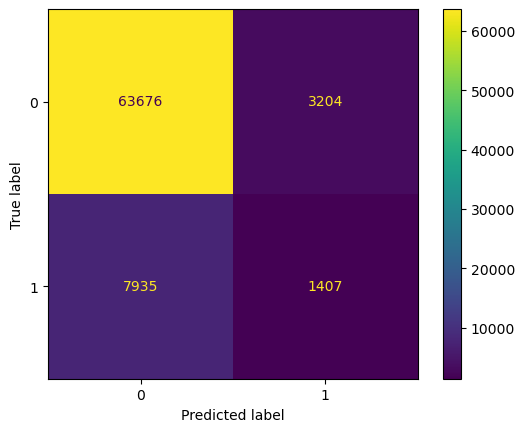

In [14]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

#Create model
model_RDF = RandomForestClassifier(n_estimators=200, random_state=42)

model_RDF.fit(x_train, y_train)

y_pred = model_RDF.predict(x_test)

print(classification_report( y_test, y_pred))
plot_confusion_matrix(model_RDF, x_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.76      0.85     66880
           1       0.31      0.76      0.44      9342

    accuracy                           0.76     76222
   macro avg       0.63      0.76      0.64     76222
weighted avg       0.88      0.76      0.80     76222



C:\Users\vy\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


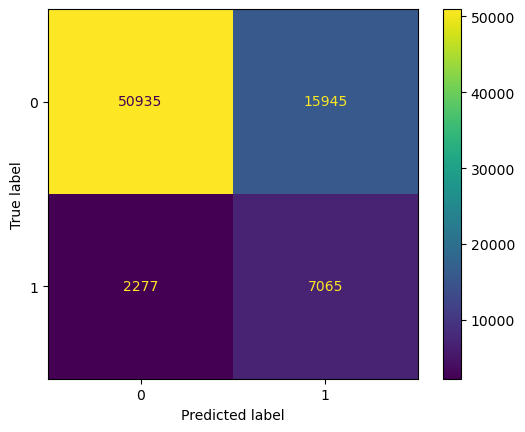

In [15]:
# SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE()
x_train_os, y_train_os = sm.fit_resample(x_train, y_train)

# SMOTE + XGBoost
model_xgb = xgb.XGBClassifier(random_state=42, n_estimators=100)
model_xgb.fit(x_train_os, y_train_os)


y_pred = model_xgb.predict(x_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(model_xgb, x_test, y_test)

              precision    recall  f1-score   support

           0       0.99      0.59      0.74     66880
           1       0.25      0.97      0.40      9342

    accuracy                           0.64     76222
   macro avg       0.62      0.78      0.57     76222
weighted avg       0.90      0.64      0.70     76222



C:\Users\vy\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


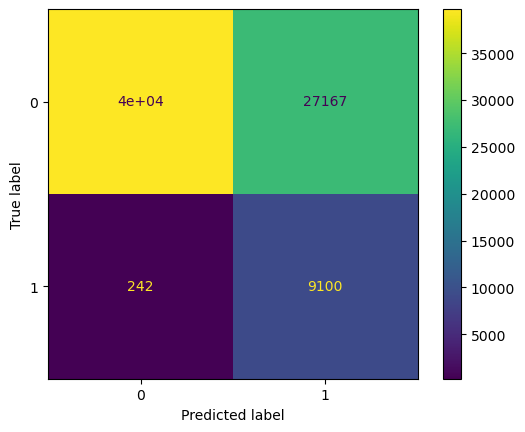

In [17]:
# SMOTE + Logistic Regression
model_log = LogisticRegression()
model_log.fit(x_train_os, y_train_os)

y_pred = model_log.predict(x_test)

print(classification_report( y_test, y_pred))
plot_confusion_matrix(model_log, x_test, y_test)

              precision    recall  f1-score   support

           0       0.92      0.84      0.88     66880
           1       0.30      0.49      0.37      9342

    accuracy                           0.80     76222
   macro avg       0.61      0.66      0.62     76222
weighted avg       0.84      0.80      0.82     76222



C:\Users\vy\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


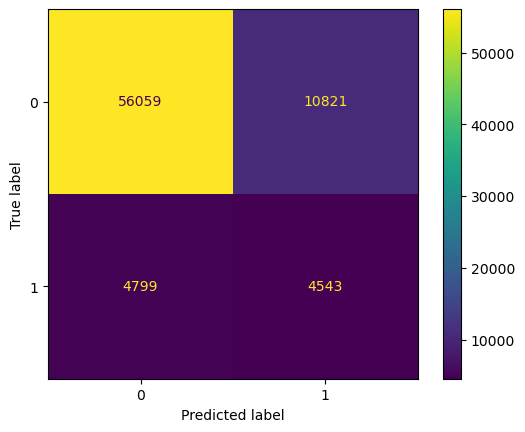

In [18]:
# Random Forest + SMOTE
from sklearn.ensemble import RandomForestClassifier

#Create model
model_RDF = RandomForestClassifier(n_estimators=200, random_state=42)

model_RDF.fit(x_train_os, y_train_os)

y_pred = model_RDF.predict(x_test)

print(classification_report( y_test, y_pred))
plot_confusion_matrix(model_RDF, x_test, y_test)

# Conclusion on first round (no drop columns)
Without any solution to solve imbalanced data, the result was worse than prediction 1
After solving imbalanced data, it's showed that:
Best model: class weight = Logistic + SMOTE - 97% catched yes cases but 57% right catched No cases
2 good model: XGBoost with 76% - 76% 
Random Forest is not applicable


              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66880
           1       0.38      0.01      0.01      9342

    accuracy                           0.88     76222
   macro avg       0.63      0.50      0.47     76222
weighted avg       0.82      0.88      0.82     76222



C:\Users\vy\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


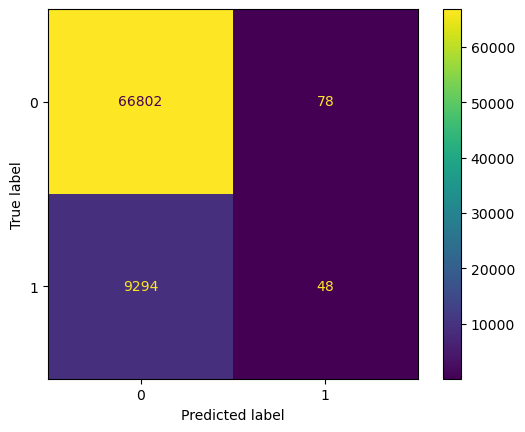

In [20]:
# Let's drop some corr columns 
df.drop(columns=['Vehicle_Less_1Year','Previously_Insured'], inplace=True)
#Train, test split
x = df.drop(columns=['Response'])
y = df['Response']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42, stratify=y)

# Apply XGBoost
model_xgb = xgb.XGBClassifier(random_state=42, n_estimators=100)
model_xgb.fit(x_train, y_train)


y_pred = model_xgb.predict(x_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(model_xgb, x_test, y_test)

              precision    recall  f1-score   support

           0       0.99      0.56      0.72     66880
           1       0.24      0.98      0.38      9342

    accuracy                           0.61     76222
   macro avg       0.62      0.77      0.55     76222
weighted avg       0.90      0.61      0.68     76222



C:\Users\vy\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


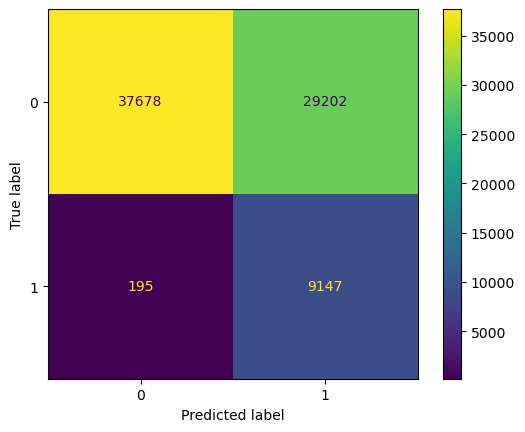

In [21]:
# So drop columns only make result worse
# Let's try with the best and second best models
# 1: Class Weight:
model2 = LogisticRegression(class_weight='balanced')
model2.fit(x_train, y_train)

y_pred = model2.predict(x_test)

print(classification_report( y_test, y_pred))
plot_confusion_matrix(model2, x_test, y_test)

              precision    recall  f1-score   support

           0       0.95      0.76      0.85     66880
           1       0.30      0.73      0.42      9342

    accuracy                           0.76     76222
   macro avg       0.62      0.74      0.63     76222
weighted avg       0.87      0.76      0.79     76222



C:\Users\vy\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


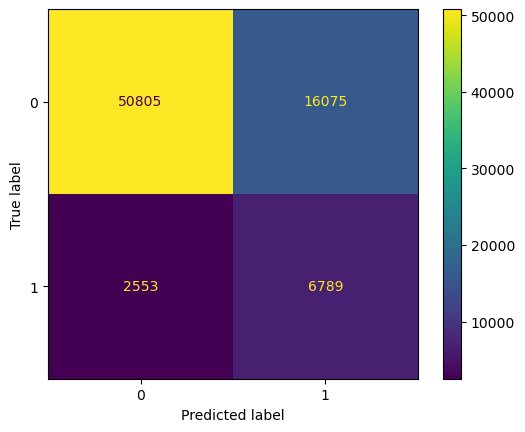

In [22]:
# XGBoost + SMOTE
x_train_os, y_train_os = sm.fit_resample(x_train, y_train)

# SMOTE + XGBoost
model_xgb = xgb.XGBClassifier(random_state=42, n_estimators=100)
model_xgb.fit(x_train_os, y_train_os)


y_pred = model_xgb.predict(x_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(model_xgb, x_test, y_test)

Looks like drop corr columns doesn't help much